In [68]:
# Vertical Viscous Flux of U momentum (Implicit part)
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
import os

In [69]:
Hs = 10
Qf = 700
file1 = xr.open_dataset('/Users/weiyangbao/Documents/Model_outputs/drag_'  + str(format(Hs,'03d')) + '/state_007.nc')
file2 = xr.open_dataset('/Users/weiyangbao/Documents/Model_outputs/drag_' + str(format(Hs,'03d')) + '/VISrI_Um_007.nc')
t0 = 60 # Start from day 30
tn = len(file1.T) # End day
state1 = file1.isel(Y = range(1,10), T = range(t0,tn)) # Remove the boundary walls in y direction
state2 = file2.isel(Y = range(1,10), T = range(t0-1,tn-1)) # Remove the boundary walls in y direction

In [70]:
X = state1.X.data
x_dist = X / 1000
depth = state1.Z.data
u0 = state1.U.data # dims = T, Z, Y, Xp1
u_ymean = (u0[:, :, :, 1:].mean(2) + u0[:, :, :, :-1].mean(2)) / 2
u = u_ymean.mean(0) # dims = Z, X

pt0 = file1.Temp.data.mean(2)[1,:,:]
mask = (pt0 == 0)
u[mask] = np.nan

vis0 = state2.VISrI_Um.data
vis_ymean = (vis0[:, :, :, 1:].mean(2) + vis0[:, :, :, :-1].mean(2)) / 2
vis = vis_ymean.mean(0)
vis[mask] = np.nan
#vt = state2.VISrI_Um.data.mean(axis=(0,2))
np.shape(vis)

(50, 50)

In [71]:
# Find the uppler and lower layer depth above the sill crest
def Layer(u):
    # Layer interface, zero velocity crossing point
    #l = np.empty(len(X)-1)
    h1 = np.empty(len(X)-2)
    for i in range(1,len(X)-1):
        l = np.where(u[:, i] < 0)[-1][0] - 1
        #h1[i-1] = -depth[l]
        # Calculate layer depth
        if l <= 9:
            h1[i-1] = -depth[l]+0.25
        elif l <= 19:
            h1[i-1] = -depth[l]+0.5
        elif l <= 29:
            h1[i-1] = -depth[l]+0.75
        elif l <= 39:
            h1[i-1] = -depth[l]+2
        elif l <= 49:
            h1[i-1] = -depth[l]+4
    return h1

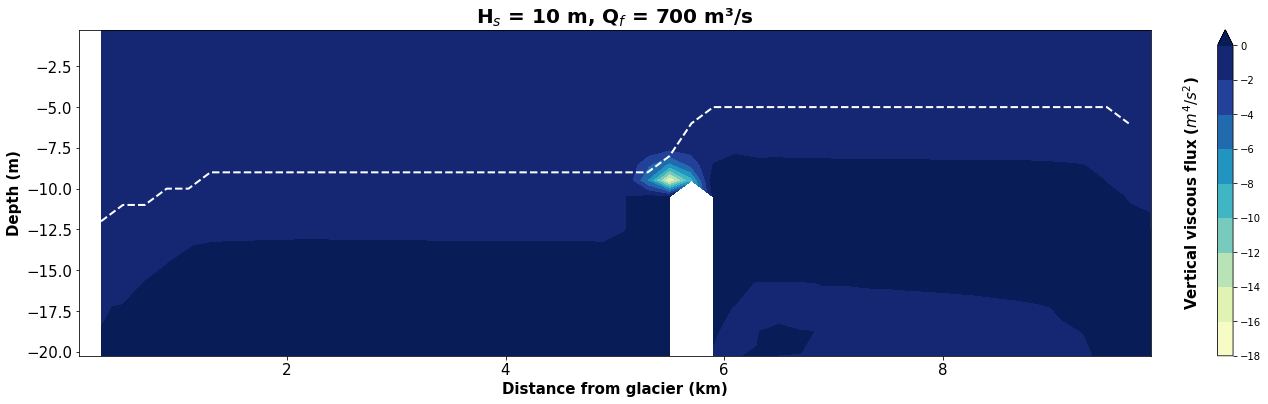

In [72]:
h1 = Layer(u)

fig_path = "/Users/weiyangbao/Documents/Model_outputs/VisFlux/"
#fig_path = "/home/1959/Jupyter_Figs/sill30/FrPseries/"
if not os.path.exists(fig_path):
    os.makedirs(fig_path)

fig, ax = plt.subplots(figsize=(24,6)) 
ca = np.linspace(-18,0,10) # Contour range for viscous term
plt.contourf(x_dist,depth[:24], vis[:24,:], ca, cmap='YlGnBu', extend='max')
plt.plot(x_dist[1:-1],-h1,color='w', linestyle='--', lw=2)
#ax.axvline(x_dist[28],color='g', lw=2)

import matplotlib.ticker
class OOMFormatter(matplotlib.ticker.ScalarFormatter):
    def __init__(self, order=0, fformat="%1.1f", offset=True, mathText=True):
        self.oom = order
        self.fformat = fformat
        matplotlib.ticker.ScalarFormatter.__init__(self,useOffset=offset,useMathText=mathText)
    def _set_orderOfMagnitude(self, nothing):
        self.orderOfMagnitude = self.oom
    def _set_format(self, vmin, vmax):
        self.format = self.fformat
        if self._useMathText:
            self.format = '$%s$' % matplotlib.ticker._mathdefault(self.format)

#cbar.ax.tick_params(labelsize=12)
cbar = plt.colorbar()
#print(cbar.values, cbar.vmax, cbar.vmin)
#cbar = plt.colorbar(ticks=np.linspace(-0.06,0.01,10))
#cbar.set_label(r'$\frac{(A_zu_z)_z}{uu_x}$', size=15, weight='bold', rotation=0)
cbar.set_label(r'Vertical viscous flux ($m^4/s^2$)', size=15, weight='bold', labelpad=-80, y=0.5)
plt.yticks(fontsize = 15)
plt.xticks(fontsize = 15)
plt.title('H$_{s}$ = '  + str(Hs) + ' m, Q$_{f}$ = ' + str(Qf) + ' m\u00B3/s', size = 20, weight = 'bold')
ax.set_xlabel('Distance from glacier (km)', size = 15, weight = 'bold')
ax.set_ylabel('Depth (m)', size = 15, weight = 'bold')

fig.savefig(fig_path + '/Vis_Um' + str(Hs) + '.png', dpi = 150, bbox_inches='tight')